# Set-up

In [32]:
import os
import sys
import numpy as np
import pandas as pd
import mudata as mu
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

In [33]:
# Path to mudata
path_mdata = "/cellar/users/aklie/data/datasets/paul15/analysis/celloracle/2024_05_21/celloracle.h5mu"

# Load data

In [34]:
# MuData
mdata = mu.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 2671 × 1999
  obs:	'louvain_annot'
  var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
  uns:	'grn', 'tutorial_grn'
  1 modality
    rna:	2671 x 1999
      obs:	'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
      var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
      uns:	'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
      obsm:	'X_diffmap', 'X_draw_graph_fa', 'X_pca'
      varm:	'PCs'
      layers:	'imputed_count', 'normalized_count', 'raw_count', 'scaled_imputed_counts'
      obsp:	'connectivities', 'distances'

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def _plot_module(
    network_data: pd.DataFrame, 
    source_name: str = None,
    target_name: str = None,
    source_col: str = 'source', 
    target_col: str = 'target', 
    score_col: str = 'score', 
    source_color: str = 'skyblue', 
    target_color: str = 'lightgrey',
    source_shape: str = 's',  # Square by default
    target_shape: str = 'o',  # Circle by default
    cmap=None
) -> None:
    """
    Visualizes a directed network module for a specified source or target node.
    
    Parameters:
    - network_data: DataFrame containing the network data.
    - source_name: The name of the source node (for source-to-target visualization).
    - target_name: The name of the target node (for target-to-source visualization).
    - source_col: Column name for source nodes.
    - target_col: Column name for target nodes.
    - score_col: Column name for interaction scores.
    - source_color: Color for the source node.
    - target_color: Color for the target nodes.
    - source_shape: Shape for the source node.
    - target_shape: Shape for the target nodes.
    - cmap: Color map for edge coloring based on weights.
    """
    # Determine the direction of visualization
    if source_name and not target_name:
        filtered_data = network_data[network_data[source_col] == source_name]
        main_node = source_name
        secondary_nodes = filtered_data[target_col].unique()
        main_shape = source_shape
        main_color = source_color
        secondary_shape = target_shape
        secondary_color = target_color
        layer_positions = {main_node: (0.5, 1), **{node: (i / max(1, len(secondary_nodes) - 1), 0) for i, node in enumerate(secondary_nodes)}}
    elif target_name and not source_name:
        filtered_data = network_data[network_data[target_col] == target_name]
        main_node = target_name
        secondary_nodes = filtered_data[source_col].unique()
        main_shape = target_shape
        main_color = target_color
        secondary_shape = source_shape
        secondary_color = source_color
        layer_positions = {main_node: (0.5, 0), **{node: (i / max(1, len(secondary_nodes) - 1), 1) for i, node in enumerate(secondary_nodes)}}
    else:
        raise ValueError("Please specify either a source_name or a target_name, but not both.")

    # Create the directed graph
    G = nx.DiGraph()
    G.add_node(main_node, shape=main_shape, color=main_color, label=main_node)
    weights = []
    for node in secondary_nodes:
        weight = filtered_data[filtered_data[target_col] == node][score_col].values[0] if source_name else filtered_data[filtered_data[source_col] == node][score_col].values[0]
        weights.append(weight)
        G.add_node(node, shape=secondary_shape, color=secondary_color, label=node)
        G.add_edge(main_node if source_name else node, node if source_name else main_node, weight=weight)

    # Determine the appropriate color map if not provided
    if cmap is None:
        if any(weight < 0 for weight in weights) and any(weight > 0 for weight in weights):
            cmap = plt.cm.bwr  # Use blue-white-red for both positive and negative values
        else:
            cmap = plt.cm.Blues if all(weight >= 0 for weight in weights) else plt.cm.Reds  # Use Blues or Reds for positive or negative only

    # Normalize the color scale
    norm = plt.Normalize(min(weights), max(weights))
    edge_colors = [cmap(norm(weight)) for weight in weights]

    # Draw the graph
    plt.figure(figsize=(10, 5))
    pos = layer_positions
    # Draw nodes by shape
    for shape in set([main_shape, secondary_shape]):
        specific_nodes = [node for node, data in G.nodes(data=True) if data['shape'] == shape]
        nx.draw_networkx_nodes(G, pos, nodelist=specific_nodes, node_shape=shape, node_color=[G.nodes[node]['color'] for node in specific_nodes],
                               edgecolors='black', node_size=700)
    nx.draw_networkx_labels(G, pos)
    edges = G.edges(data=True)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors, width=2, arrowstyle='-|>', arrowsize=20)

    # Add a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Interaction Strength', format='%.3f')
    plt.axis('off')  # Turn off the axis
    plt.show()

# Link selection

In [51]:
# tf2r link parameters
tf2r_score = 50
tf2r_cluster_key = "cluster"
tf2r_cluster = "global"

# r2g link parameters
r2g_score = 0.1
r2g_cluster_key = "cluster"
r2g_cluster = "global"

# grn link parameters
filter_by_tf2r_and_r2g = False
pval = 0.001
score = 0
ntop = 2000
layer = None
cluster_key = "cluster"
cluster = "MEP_0"
grn_key = "grn"
min_regulators = 0
min_targets = 0

# TF to region linkages

In [338]:
tf2r = mdata.uns["tf2r"]
print(f"Initial TF binding events called: {tf2r.shape[0]}")

Initial TF binding events called: 5002583


In [339]:
# Choose a cluster of interest (based on cluster column values in standardized outputs)
tf2r = tf2r[tf2r[tf2r_cluster_key] == tf2r_cluster]
print(f"TF binding events in cluster {tf2r_cluster}: {tf2r.shape[0]}")

TF binding events in cluster global: 5002583


In [340]:
# Filter TF binding events based on score
tf2r = tf2r[tf2r["score"] > tf2r_score]
print(f"TF binding events in cluster {tf2r_cluster} with score > {tf2r_score}: {tf2r.shape[0]}")

TF binding events in cluster global with score > 5: 5002583


In [341]:
# Get the unique regions and TFs
regions = tf2r["cre"].unique()
tfs = tf2r["tf"].unique()
print(f"Unique regions: {len(regions)} | Unique TFs: {len(tfs)}")

Unique regions: 34291 | Unique TFs: 820


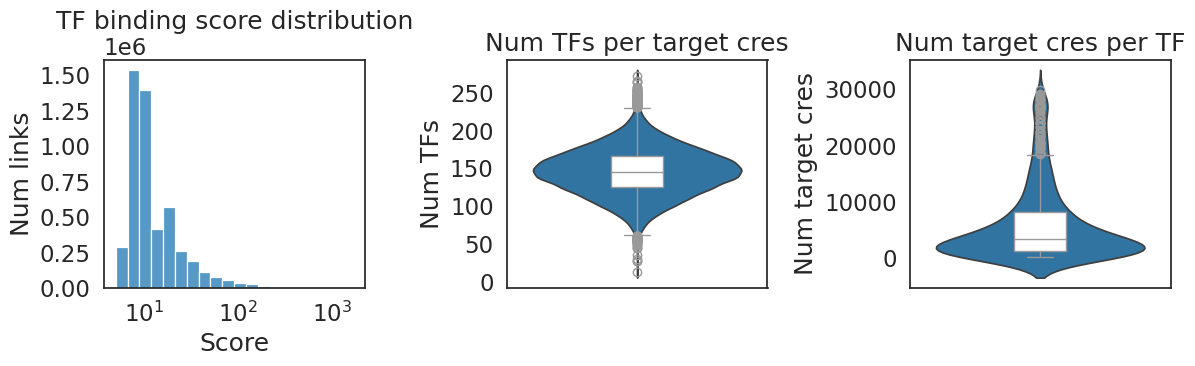

In [342]:
# Get plot of how many gene each gene is connected to
num_connections_per_tf = tf2r.groupby("tf").size()
num_connections_per_cre = tf2r.groupby("cre").size()
with sns.plotting_context("notebook", font_scale=1.5):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Plot score distribution
    sns.histplot(tf2r["score"], bins=20, ax=ax[0], log_scale=True)
    ax[0].set_xlabel("Score")
    ax[0].set_ylabel("Num links")
    ax[0].set_title("TF binding score distribution")

    sns.violinplot(num_connections_per_cre, inner=None, ax=ax[1])
    sns.boxplot(num_connections_per_cre, color="white", width=0.2, ax=ax[1])
    ax[1].set_ylabel("Num TFs")
    ax[1].set_title("Num TFs per target cres")

    sns.violinplot(num_connections_per_tf, inner=None, ax=ax[2])
    sns.boxplot(num_connections_per_tf, color="white", width=0.2, ax=ax[2])
    ax[2].set_ylabel("Num target cres")
    ax[2].set_title("Num target cres per TF")

    plt.tight_layout()

/tmp/ipykernel_979107/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


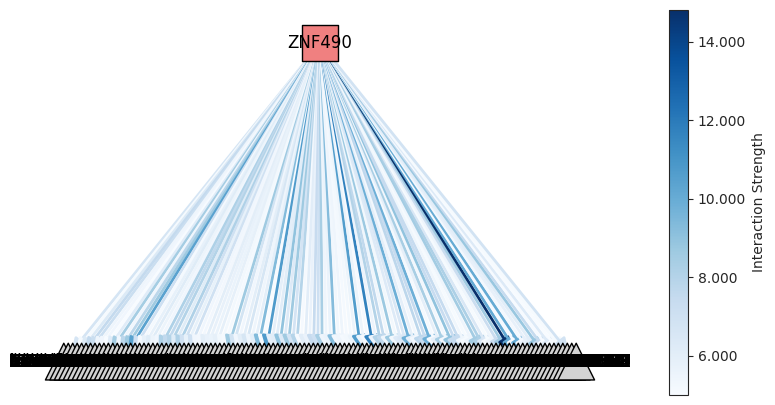

In [344]:
# Select a TF with a low number of connections
tf = num_connections_per_tf.idxmin()
_plot_module(
    network_data=tf2r,
    source_name=tf,
    target_name=None,
    source_col="tf", 
    target_col="cre", 
    score_col="score", 
    source_color='lightcoral', 
    target_color='lightgrey', 
    source_shape='s', 
    target_shape='^'
)

/tmp/ipykernel_979107/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


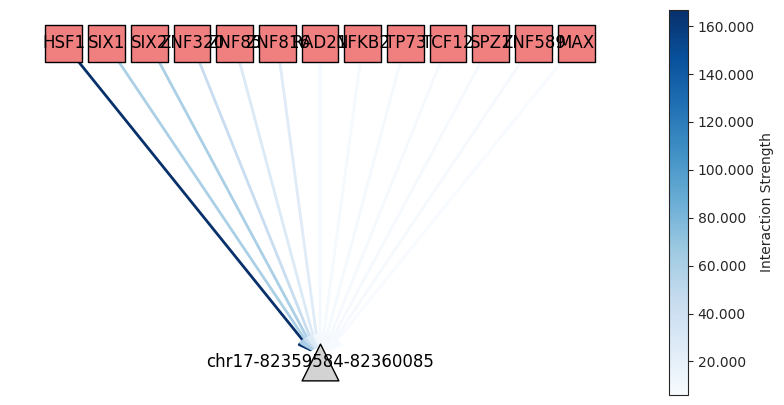

In [345]:
# Select a CRE target with a low number of connections
cre = num_connections_per_cre.idxmin()
_plot_module(
    network_data=tf2r,
    source_name=None,
    target_name=cre,
    source_col="tf", 
    target_col="cre", 
    score_col="score", 
    source_color='lightcoral', 
    target_color='lightgrey', 
    source_shape='s', 
    target_shape='^'
)

# Region to gene linkages

In [346]:
r2g = mdata.uns["r2g"]
print(f"Initial region to gene linking has {len(r2g)} edges")

Initial region to gene linking has 46095 edges


In [347]:
# Choose a cluster of interest (based on cluster column values in standardized outputs)
r2g = r2g[r2g[r2g_cluster_key] == r2g_cluster]
print(f"Region to gene linking for {r2g_cluster} has {len(r2g)} edges")

Region to gene linking for global has 46095 edges


In [348]:
# Filter r2g based on score
r2g = r2g[r2g["score"] > r2g_score]
print(f"Region to gene linking after filtering on edge strength has {len(r2g)} edges")

Region to gene linking after filtering on edge strength has 46095 edges


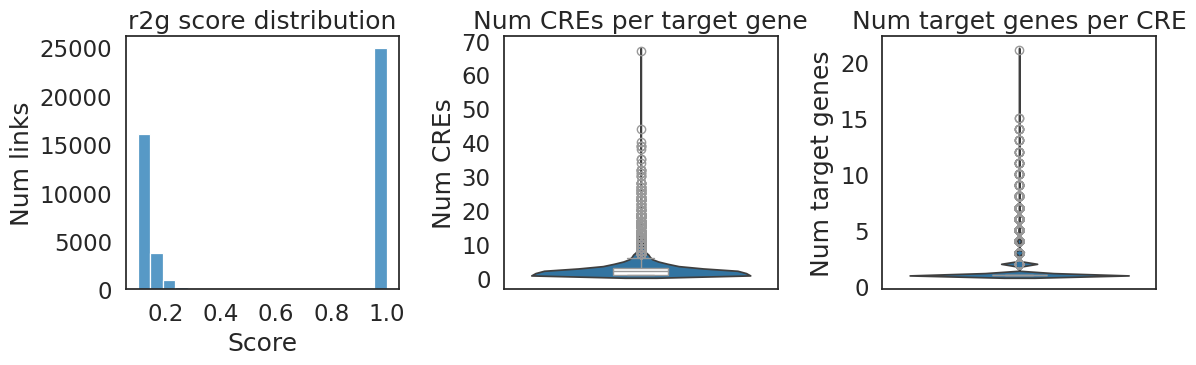

/tmp/ipykernel_979107/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


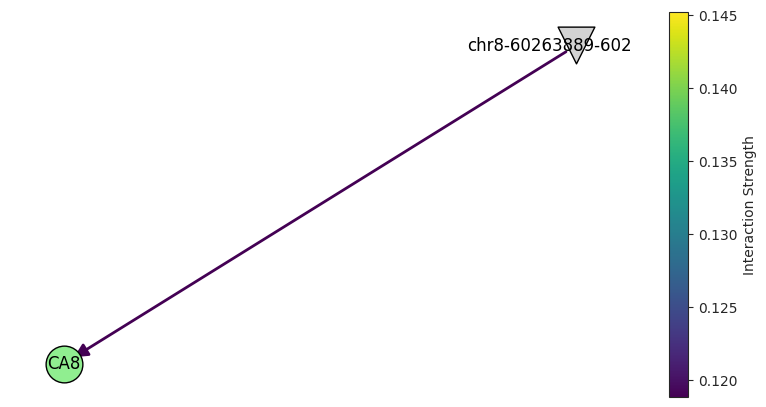

In [367]:
# Select a andom CRE, not the minimum
cre = num_connections_per_cre.sample(1).index[0]
_plot_module(
    network_data=r2g,
    source_name=cre,
    target_name=None,
    source_col="cre", 
    target_col="gene", 
    score_col="score", 
    source_color='lightgrey', 
    target_color='lightgreen', 
    source_shape='v', 
    target_shape='o',
    cmap=plt.cm.viridis
)

/tmp/ipykernel_979107/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


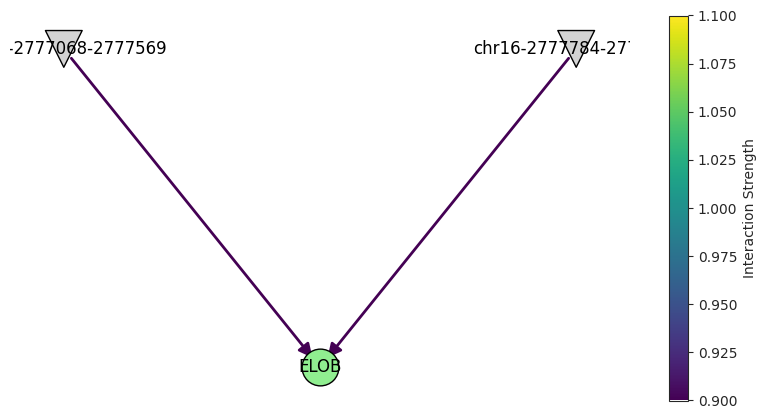

In [368]:
# Load data

# GRN

In [52]:
# Read in grns
grn = mdata.uns[grn_key]
print(f"Initial GRN has {len(grn)} edges")

Initial GRN has 1718396 edges


In [46]:
# If needed, filter grn based on TF binding and region to gene linking
if filter_by_tf2r_and_r2g:
    grn["tf_gene"] = grn["tf"] + "_" + grn["gene"]
    base_grn_adj_list["tf_gene"] = base_grn_adj_list["tf"] + "_" + base_grn_adj_list["gene"]
    grn = grn[grn["tf_gene"].isin(base_grn_adj_list["tf_gene"])]
    grn = grn.drop(["tf_gene"], axis=1)
    print(f"GRN after filtering on base GRN has {len(grn)} edges")

In [53]:
# Choose a cluster of interest (based on cluster column values in standardized outputs)
grn = grn[grn[cluster_key] == cluster]
print(f"GRN for {cluster} has {len(grn)} edges")

GRN for MEP_0 has 73773 edges


In [54]:
# If pval and score are not None, filter based on these thresholds
if pval is not None:
    grn = grn[grn["pval"] <= pval]
if score is not None:
    grn = grn[np.abs(grn["score"]) >= score]
print(f"GRN after filtering on edge strength has {len(grn)} edges")

GRN after filtering on edge strength has 32983 edges


In [55]:
# Keep only the top ntop regulators if ntop is not None, use abs value of score
if ntop is not None:
    grn["score_abs"] = np.abs(grn["score"])
    grn = grn.sort_values("score_abs", ascending=False)
    grn = grn.head(ntop)
    grn = grn.drop(columns="score_abs")
print(f"GRN after filtering on top regulators has {len(grn)} edges")

GRN after filtering on top regulators has 2000 edges


In [56]:
# Filter out any tfs that regulate fewer than min_targets genes
tfs = grn["tf"].value_counts()
tfs = tfs[tfs > min_targets].index
grn = grn[grn["tf"].isin(tfs)]
print(f"GRN after filtering on minimum number of targets has {len(grn)} edges")

GRN after filtering on minimum number of targets has 2000 edges


In [57]:
# Filter out any genes that are regulated by fewer than min_regulators tfs
genes = grn["gene"].value_counts()
genes = genes[genes >= min_regulators].index
grn = grn[grn["gene"].isin(genes)]
print(f"GRN after filtering on minimum number of regulators has {len(grn)} edges")

GRN after filtering on minimum number of regulators has 2000 edges


In [58]:
# Get list of unique TFs and target genes
tfs = grn["tf"].unique()
genes = grn["gene"].unique()
print(f"GRN has {len(tfs)} TFs and {len(genes)} target genes")

GRN has 93 TFs and 472 target genes


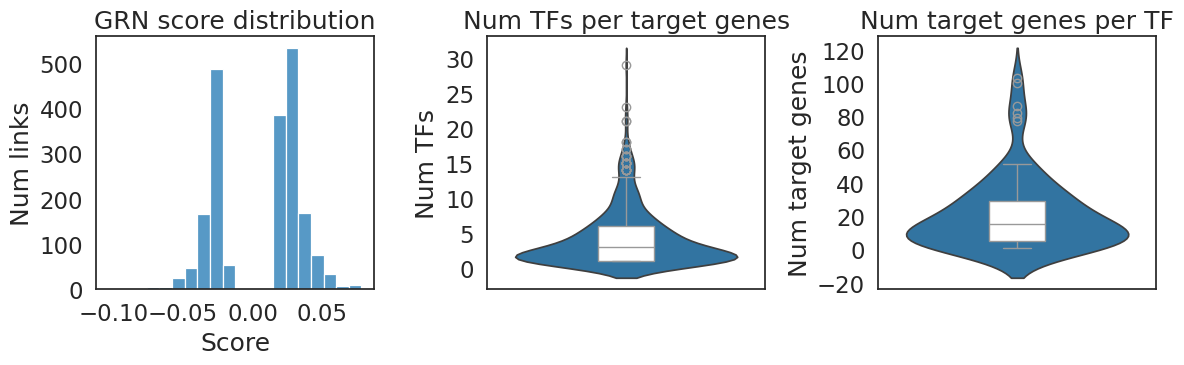

In [59]:
# Main three plots
num_connections_per_gene = grn.groupby("gene").size()
num_connections_per_tf = grn.groupby("tf").size()
with sns.plotting_context("notebook", font_scale=1.5):
    _, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Plot score distribution
    sns.histplot(grn["score"], bins=20, ax=ax[0])
    ax[0].set_xlabel("Score")
    ax[0].set_ylabel("Num links")
    ax[0].set_title("GRN score distribution")

    sns.violinplot(num_connections_per_gene, inner=None, ax=ax[1])
    sns.boxplot(num_connections_per_gene, color="white", width=0.2, ax=ax[1])
    ax[1].set_ylabel("Num TFs")
    ax[1].set_title("Num TFs per target genes")

    sns.violinplot(num_connections_per_tf, inner=None, ax=ax[2])
    sns.boxplot(num_connections_per_tf, color="white", width=0.2, ax=ax[2])
    ax[2].set_ylabel("Num target genes")
    ax[2].set_title("Num target genes per TF")

    plt.tight_layout()

In [67]:
tf = "Gata1"
grn[grn["tf"] == tf].sort_values("score", ascending=False)

,tf,gene,score,pval,cluster
42233,Gata1,Myb,0.058931,2.446391e-11,MEP_0
42298,Gata1,Myc,0.046967,6.613371e-08,MEP_0
5562,Gata1,Aqp1,0.042375,1.655946e-09,MEP_0
41655,Gata1,Mt1,0.039399,4.251255e-09,MEP_0
16737,Gata1,Ctsd,0.035602,3.144100e-10,MEP_0
51371,Gata1,Ppm1g,0.032601,1.873736e-15,MEP_0
37570,Gata1,Ly6e,0.030089,2.146119e-07,MEP_0
46506,Gata1,Optn,0.027732,5.950626e-14,MEP_0
18060,Gata1,Dcaf8,0.027515,2.542277e-08,MEP_0
70470,Gata1,Tspo2,0.026091,7.363517e-08,MEP_0


/tmp/ipykernel_2037120/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


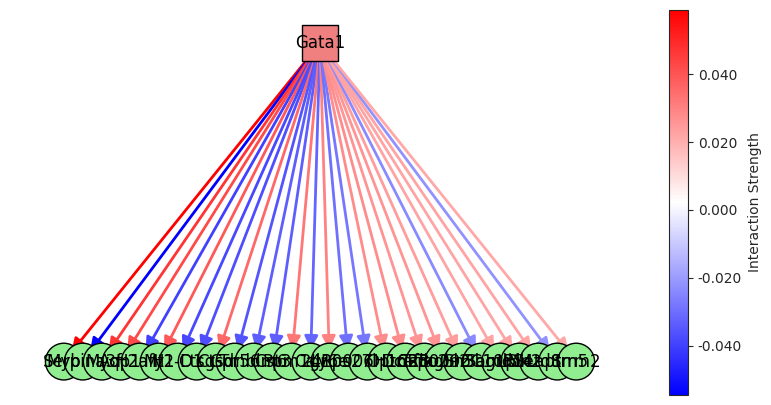

In [69]:
# Test the updated function with the same TF
_plot_module(
    network_data=grn,
    source_name=tf,
    target_name=None,
    source_col="tf", 
    target_col="gene", 
    score_col="score", 
    source_color='lightcoral', 
    target_color='lightgreen', 
    source_shape='s', 
    target_shape='o',
)

/tmp/ipykernel_2037120/45957929.py:92: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Interaction Strength', format='%.3f')


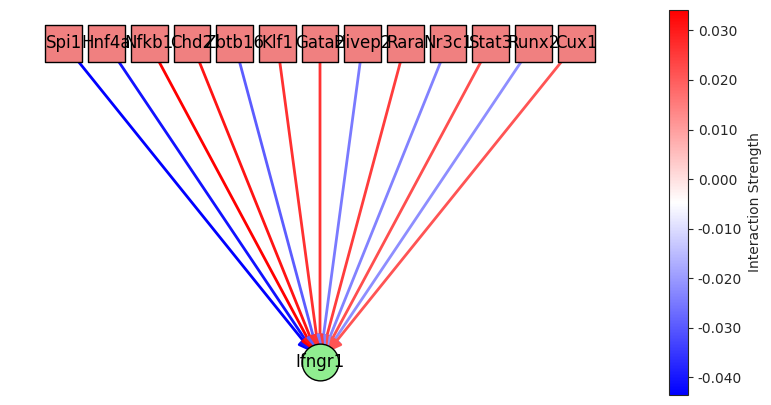

In [63]:
# Test the updated function with a random gene
gene = num_connections_per_gene.sample(1).index[0]
_plot_module(
    network_data=grn,
    source_name=None,
    target_name=gene,
    source_col="tf", 
    target_col="gene", 
    score_col="score", 
    source_color='lightcoral', 
    target_color='lightgreen', 
    source_shape='s', 
    target_shape='o',
)

# Centrality

In [64]:
from igraph import Graph

def create_igraph_from_df(
    df,
    source_col="source",
    target_col="target",
    score_col="score",
    directed=True
):
    g = Graph.DataFrame(df[[source_col, target_col]], directed=directed, use_vids=False)
    g.es["weight"] = np.abs(df[score_col].values)
    return g

def node_scores(g):
    df = g.get_vertex_dataframe()
    for i in ["all", "in", "out"]:
        df[f"degree_{i}"] = g.degree(mode=i)
        df[f"degree_centrality_{i}"] = df[f"degree_{i}"] / (df.shape[0]-1)
    df["betweenness_centrality"] = g.betweenness(directed=True, weights="weight")
    df["eigenvector_centrality"] = g.eigenvector_centrality(directed=False, weights="weight")
    df["page_rank"] = g.pagerank(weights="weight")
    df = df.set_index("name")
    df.index.name = None
    return df

In [70]:
# Get node scores
grn_graph = create_igraph_from_df(grn, source_col="tf", target_col="gene", score_col="score", directed=True)
grn_node_scores = node_scores(grn_graph)
grn_node_scores.sort_values("degree_centrality_all", ascending=False).head(25)

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,page_rank
Gata2,109,0.204503,6,0.011257,103,0.193246,5050.0,1.000000,0.001834
E2f4,101,0.189493,1,0.001876,100,0.187617,323.0,0.703592,0.001703
Myc,98,0.183865,12,0.022514,86,0.161351,6130.0,0.829436,0.002122
Nfe2,91,0.170732,12,0.022514,79,0.148218,3640.0,0.746576,0.002202
Klf1,90,0.168856,8,0.015009,82,0.153846,6317.0,0.531325,0.008717
Chd2,79,0.148218,2,0.003752,77,0.144465,2061.0,0.651889,0.001706
Myb,53,0.099437,11,0.020638,42,0.078799,2473.0,0.498042,0.002288
Zbtb7a,52,0.097561,1,0.001876,51,0.095685,4231.0,0.441413,0.001795
Mef2c,50,0.093809,0,0.000000,50,0.093809,0.0,0.470223,0.001612
Elf1,50,0.093809,3,0.005629,47,0.088180,1425.0,0.452273,0.001854


# DONE!

---